<a href="https://colab.research.google.com/github/mostafa-ja/graph-tutorial/blob/master/Illegal_Bitcoin_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Kaggle API.
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 4.Run the following code to configure the path to “kaggle.json”
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d ellipticco/elliptic-data-set
!unzip elliptic-data-set.zip

 88% 129M/146M [00:00<00:00, 149MB/s]
100% 146M/146M [00:00<00:00, 165MB/s]
Archive:  elliptic-data-set.zip
  inflating: elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_features.csv  


In [2]:
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
path = '/content'

edges = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
classes = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
features = pd.read_csv(path + "/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

In [5]:
# rename features according to data description in paper
rename_dict = dict(
    zip(
        range(0, 167),
        ["txId", "time_step"]
        + [f"local_{i:02d}" for i in range(1, 94)]
        + [f"aggr_{i:02d}" for i in range(1, 73)],
    )
)
features.rename(columns=rename_dict, inplace=True)

In [6]:
# rename the classes to ints that can be handled by pytorch as labels
classes["label"] = classes["class"].replace(
    {"unknown": -1,  # unlabeled nodes
     "2": 0,  # labeled licit nodes
     #"1": 1,  # labeled illicit nodes
    }
).astype(int)

In [7]:
features.head()

,txId,time_step,local_01,local_02,local_03,local_04,local_05,local_06,local_07,local_08,...,aggr_63,aggr_64,aggr_65,aggr_66,aggr_67,aggr_68,aggr_69,aggr_70,aggr_71,aggr_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [8]:
print(f"Number of missing data points: {features.isna().sum().sum()+classes.isna().sum().sum()}")
print(f"Number of nodes (transactions): {features['txId'].nunique()}") #nunique() method returns the number of unique values for each column
print(f"Number of edges: {edges.shape[0]}")
print(f"Number of classes: {classes['class'].nunique()}")
print(f"Timesteps range from {features['time_step'].min()} to {features['time_step'].max()}")

Number of missing data points: 0
Number of nodes (transactions): 203769
Number of edges: 234355
Number of classes: 3
Timesteps range from 1 to 49


#Constructing the transaction graph

In [9]:
g_nx = nx.MultiDiGraph()  # A directed graph class that can store multiedges, Self loops are allowed
g_nx.add_nodes_from(
    zip(classes["txId"], [{"label": v} for v in classes["label"]])
)
g_nx.add_edges_from(zip(edges["txId1"], edges["txId2"]));

In [10]:
print(f"Graph with {g_nx.number_of_nodes()} nodes and {g_nx.number_of_edges()} edges.")
print(f"Number of connected components: {len(list(nx.weakly_connected_components(g_nx)))}")

Graph with 203769 nodes and 234355 edges.
Number of connected components: 49


In [11]:
components = list(nx.weakly_connected_components(g_nx))
g_nx_t_list = [g_nx.subgraph(components[i]) for i in range(0,len(components))]

<ipython-input-12-d4638928d63c>:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


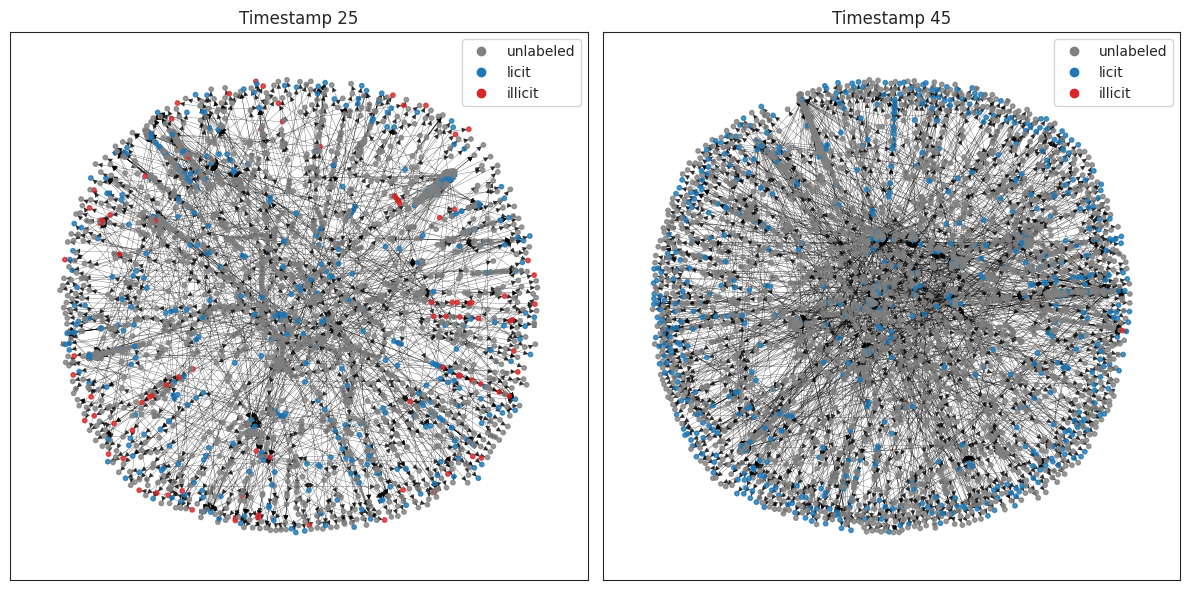

In [12]:
def create_legend(ax, colors):
    labels = ['unlabeled', 'licit', 'illicit']
    handles = [plt.Line2D([], [], color=color, marker='o', linestyle='None') for color in colors]
    ax.legend(handles, labels)

with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    for i, t in enumerate([25, 45]):
        node_label = list(nx.get_node_attributes(g_nx_t_list[t], 'label').values())
        mapping = {-1: 'grey', 0: 'C0', 1: 'C3'}
        node_color = [mapping[l] for l in node_label]

        nx.draw_networkx(
            g_nx_t_list[t],
            node_size=10,
            node_color=node_color,
            with_labels=False,
            width=0.2,
            alpha=0.8,
            arrowsize=8,
            ax=ax[i]
        )

        ax[i].set_title(f'Timestamp {t}')
        create_legend(ax[i], ['grey', 'C0', 'C3'])

    plt.tight_layout()

Text(0.5, 0, 'timestep')

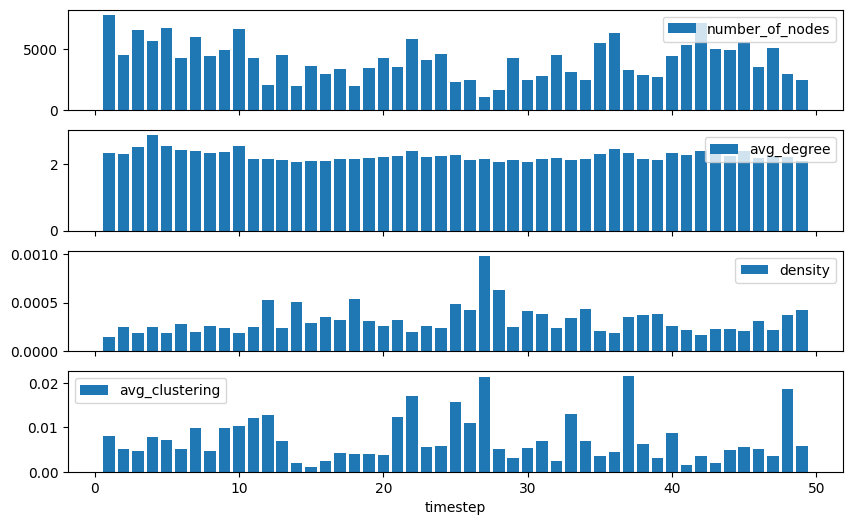

In [13]:

g_metrics = {
    'timestep': np.arange(1, 50),
    'number_of_nodes': [graph.number_of_nodes() for graph in g_nx_t_list],
    'avg_degree': [np.mean(list(dict(nx.degree(graph)).values())) for graph in g_nx_t_list],
    'density': [nx.density(graph) for graph in g_nx_t_list],
    'avg_clustering': [nx.average_clustering(nx.DiGraph(graph)) for graph in g_nx_t_list]
}

fig, ax = plt.subplots(len(g_metrics) - 1, 1, figsize=(10, 6), sharex=True)

for i, label in enumerate(list(g_metrics.keys())[1:]):
    ax[i].bar(g_metrics['timestep'], g_metrics[label], label=label)
    ax[i].legend()

plt.xlabel('timestep')

In [14]:
print(f"Average density of the graphs across all timesteps: {np.mean(g_metrics['density']):.6f}")
print(f"Average degree of all nodes across all timesteps: {np.mean(list(dict(nx.degree(g_nx)).values())):.2f}")

Average density of the graphs across all timesteps: 0.000318
Average degree of all nodes across all timesteps: 2.30


# secound part

In [15]:
# Merge features and labels
df = features.merge(classes, how="left", left_on="txId", right_on="txId")

# Sort the DataFrame and reset index
df.sort_values("txId", inplace=True)
df.reset_index(drop=True, inplace=True)

# Check the length of df and classes
if len(df) != len(classes):
    print("Error: Lengths of df and classes do not match.")

# Drop unclassified and isolated nodes
classified_nodes = set(classes[classes["label"] != -1]["txId"].values)
classified_edges = edges[(edges["txId1"].isin(classified_nodes)) & (edges["txId2"].isin(classified_nodes))].copy()
non_isolated_nodes = set(classified_edges["txId1"].values).union(classified_edges["txId2"].values)
classified_df = df[df["txId"].isin(non_isolated_nodes)].copy()


In [16]:
classified_df.head()

,txId,time_step,local_01,local_02,local_03,local_04,local_05,local_06,local_07,local_08,...,aggr_65,aggr_66,aggr_67,aggr_68,aggr_69,aggr_70,aggr_71,aggr_72,class,label
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,2,0
7,6418,48,-0.125229,7.538599,2.128587,7.381781,0.095076,7.602324,0.547008,-0.163537,...,-0.197237,0.303447,-0.098889,0.931406,1.041565,0.371499,0.790060,0.779125,2,0
8,7952,48,0.967162,-0.210553,-1.756361,-0.121970,92.556494,-0.113002,-0.061584,1.002891,...,0.321431,0.268810,-0.098889,1.162100,0.485146,0.303509,-0.553520,-0.578865,2,0
12,9363,48,-0.027465,0.177798,1.573595,-0.121970,0.234026,-0.113002,-0.061584,-0.014750,...,-0.058102,-0.216309,-0.098889,0.662264,0.786576,0.860861,-0.431555,-0.124795,2,0


In [17]:
# Only use nodes with timestamp 0 - 20
classified_nodes = set(classified_df[classified_df['time_step'].between(0, 20)]["txId"].values)
classified_edges = edges.loc[(edges["txId1"].isin(classified_nodes)) & (edges["txId2"].isin(classified_nodes))].copy()
non_isolated_nodes = set(classified_edges["txId1"].values).union(classified_edges["txId2"].values)
classified_df = df[df["txId"].isin(non_isolated_nodes)].copy()
print(len(non_isolated_nodes))


14866


In [18]:
classified_df.head()

,txId,time_step,local_01,local_02,local_03,local_04,local_05,local_06,local_07,local_08,...,aggr_65,aggr_66,aggr_67,aggr_68,aggr_69,aggr_70,aggr_71,aggr_72,class,label
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2,0
41,32496,11,-0.169441,0.213110,1.573595,0.103143,9.861288,0.138585,-0.061584,-0.163639,...,0.198847,0.313849,-0.098889,9.774657,2.879435,0.225842,-0.154528,-0.184329,2,0
61,68869,1,-0.114267,-0.184668,-1.201369,0.028105,-0.043875,-0.113002,0.547008,-0.161652,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2,0
67,74044,8,-0.171080,0.257040,1.573595,0.028105,9.841438,0.054722,-0.061584,-0.163633,...,0.352573,0.350766,-0.098889,15.465096,2.305430,0.007406,-0.154953,-0.207190,2,0
73,89273,1,5.202107,-0.210553,-1.756361,-0.121970,260.090707,-0.113002,-0.061584,5.335864,...,0.118347,0.091066,-0.098889,0.854508,-0.066727,-0.150067,-0.080760,-0.070977,2,0


In [19]:
classified_df.sort_values('time_step').reset_index(drop=True)

,txId,time_step,local_01,local_02,local_03,local_04,local_05,local_06,local_07,local_08,...,aggr_65,aggr_66,aggr_67,aggr_68,aggr_69,aggr_70,aggr_71,aggr_72,class,label
0,209968186,1,-0.171840,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163632,...,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,2,0
1,230578984,1,-0.170509,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.161114,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2,0
2,230578985,1,-0.172856,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163581,...,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,2,0
3,230578991,1,-0.169818,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160407,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2,0
4,230578992,1,-0.172601,-0.184668,-1.201369,0.028105,-0.043875,0.054722,-0.061584,-0.163618,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14861,209124207,20,-0.172706,-0.181302,-0.091383,-0.121970,-0.043875,-0.113002,-0.061584,-0.163362,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,1,1
14862,209118635,20,-0.045172,-0.180399,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.032876,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,2,0
14863,209118496,20,0.608112,-0.180265,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,0.635530,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2,0
14864,209479773,20,-0.172568,-0.145840,-0.646376,-0.121970,-0.063725,-0.113002,-0.061584,-0.163220,...,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2,0


In [20]:
# reindex nodes
classified_df = classified_df.sort_values('time_step').reset_index(drop=True)
old2new = {old:new for new, old in enumerate(classified_df['txId'].values)}
a = classified_edges["txId1"].map(old2new)
b = classified_edges["txId2"].map(old2new)
classified_edges["txId1"] = a
classified_edges["txId2"] = b
classified_df['txId'] = classified_df['txId'].map(old2new)

classified_df.head(3)

,txId,time_step,local_01,local_02,local_03,local_04,local_05,local_06,local_07,local_08,...,aggr_65,aggr_66,aggr_67,aggr_68,aggr_69,aggr_70,aggr_71,aggr_72,class,label
0,0,1,-0.171840,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163632,...,-0.979074,-0.978556,-0.098889,-0.08749,-0.084674,-0.140597,1.519700,1.521399,2,0
1,1,1,-0.170509,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.161114,...,1.461330,1.461369,0.018279,-0.08749,-0.131155,-0.097524,-0.120613,-0.119792,2,0
2,2,1,-0.172856,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163581,...,-0.979074,-0.978556,-0.098889,-0.08749,-0.084674,-0.140597,1.519700,1.521399,2,0


In [21]:
classified_edges

,txId1,txId2
5,1207,411
8,1368,691
15,1269,899
26,500,1602
33,1059,1496
...,...,...
106736,14599,14347
106760,14556,14261
106764,14553,14442
106793,14589,14313


In [22]:
# edges
edge_index = torch.tensor(classified_edges.values, dtype=torch.long)
edge_index = edge_index.t().contiguous()

# labels 
labels = classified_df["label"].values
labels = torch.tensor(labels, dtype=torch.float)

# timestamps 
timestamps = set(classified_df['time_step'].values)

# features
features = torch.tensor(classified_df.drop(['txId', 'time_step', "class",'label'], axis=1).values, dtype=torch.float)

# construct torch_geometric.data.Data
data = Data(x=features, edge_index=edge_index, y=labels)



In [23]:
features.shape

torch.Size([14866, 165])

In [24]:
data.y.shape

torch.Size([14866])

In [25]:
data.y

tensor([0., 0., 0.,  ..., 0., 0., 1.])

In [26]:
len(labels)

14866

In [27]:
# generate array of indices
indices = np.arange(len(labels))

# split indices into train, val, and test sets
train_indices, test_indices, train_labels, test_labels = train_test_split(indices, labels, test_size=0.3, stratify=labels, random_state=42) 
val_indices, test_indices, val_labels, test_labels = train_test_split(test_indices, test_labels, test_size=0.5, stratify=test_labels, random_state=42) 

In [36]:
def LPA(k):
  # k:predict after k steps
  # given  edge indices and edge attributes convert to a single  adjacency matrix.
  A = torch_geometric.utils.to_dense_adj(data.edge_index, max_num_nodes=data.num_nodes).squeeze(0).to(DEVICE)
  selfloop = torch.diag(torch.ones(A.shape[0])).to(DEVICE)
  A += selfloop
  D = torch.diag(torch.sum(A, dim=1))
  D_inverse = torch.inverse(D).to(DEVICE)
  Y = data.y.clone().type(torch.LongTensor)
  Y[val_indices] = torch.zeros(len(val_indices)).type(torch.LongTensor)
  Y[test_indices] = torch.zeros(len(test_indices)).type(torch.LongTensor)
  Y = torch.nn.functional.one_hot(Y).type(torch.FloatTensor).to(DEVICE)
  for _ in range(k+1):
    Y_new = torch.matmul(torch.matmul(D_inverse, A), Y)
    Y_new[train_indices] = Y[train_indices]
    Y = Y_new
  Y = torch.argmax(Y, dim=1)
  return Y 

In [29]:
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda:0"

if data.is_directed():
  edge_index = torch_geometric.utils.to_undirected(data.edge_index)
  data = Data(x=data.x, edge_index=edge_index, y=data.y)

f1s = []
for k in range(1, 10):
  y = LPA(k)
  f1 = f1_score(data.y.cpu()[val_indices], y.cpu()[val_indices])
  f1s.append(f1)
  print(k, f"\t f1: {f1}")

1 	 f1: 0.39999999999999997
2 	 f1: 0.430939226519337
3 	 f1: 0.448087431693989
4 	 f1: 0.4623655913978495
5 	 f1: 0.48677248677248675
6 	 f1: 0.49473684210526314
7 	 f1: 0.49473684210526314
8 	 f1: 0.49473684210526314
9 	 f1: 0.49473684210526314


In [37]:
best_k = 6
y = LPA(best_k)
f1 = f1_score(data.y.cpu()[test_indices], y.cpu()[test_indices])
acc = accuracy_score(data.y.cpu()[test_indices], y.cpu()[test_indices])
pre = precision_score(data.y.cpu()[test_indices], y.cpu()[test_indices])
rec = recall_score(data.y.cpu()[test_indices], y.cpu()[test_indices])
print("test performance:")
print('--------------')
print(f"f1: {f1}")
print(f"acc: {acc}")
print(f"pre: {pre}")
print(f"rec: {rec}")
print('****************')
print("Confusion matrix:")
print(confusion_matrix(data.y.cpu()[test_indices], y.cpu()[test_indices]))

test performance:
--------------
f1: 0.3977272727272727
acc: 0.9524663677130045
pre: 0.7954545454545454
rec: 0.26515151515151514
****************
Confusion matrix:
[[2089    9]
 [  97   35]]


In [31]:
# GCN
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GCN, self).__init__()
        
        convs = [GCNConv(input_dim, hidden_dim)] + [GCNConv(hidden_dim, hidden_dim) for _ in range(num_layers-2)] + [GCNConv(hidden_dim, output_dim)]
        self.convs = torch.nn.ModuleList(convs)
        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim) for _ in range(num_layers-1)])
        self.dropout = dropout
        self.softmax = torch.nn.Softmax(dim=1)

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, data, adj_t=None):
        x, edge_index = data.x, data.edge_index
        for i, layer in enumerate(self.convs):
          x = layer(x, edge_index)
          if i < len(self.convs)-1:
            x = self.bns[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        out = self.softmax(x)
        return out

In [32]:
model = GCN(165,100,2,2,0.415).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()
t = 0.45
metrics = {"loss":{"train": [], "val": []},
               "accuracy":{"train": [], "val": []},
               "precision":{"train": [], "val": []},
               "recall":{"train": [], "val": []},
               "f1_score":{"train": [], "val": []},
              }
for epoch in range(500):

    model.train()
    optimizer.zero_grad()
    data = data.to(DEVICE)
    out = model(data)

    tmp = torch.nn.functional.one_hot(data.y.type(torch.long)).type(torch.float)
    loss = criterion(out[train_indices], tmp[train_indices])
    metrics["loss"]["train"].append(loss.cpu().detach())
    y = out.detach()[:, 1]
    y = (y > t).type(torch.long)

    
    train_acc = accuracy_score(data.y.cpu()[train_indices], y.cpu()[train_indices])
    train_precision = precision_score(data.y.cpu()[train_indices], y.cpu()[train_indices])
    train_recall = recall_score(data.y.cpu()[train_indices], y.cpu()[train_indices])
    train_f1_score = f1_score(data.y.cpu()[train_indices], y.cpu()[train_indices])
    metrics["accuracy"]["train"].append(train_acc)
    metrics["precision"]["train"].append(train_precision)
    metrics["recall"]["train"].append(train_recall)
    metrics["f1_score"]["train"].append(train_f1_score)

    loss.backward()
    optimizer.step()


    model.eval()
    with torch.no_grad():
      val_acc = accuracy_score(data.y.cpu()[val_indices], y.cpu()[val_indices])
      val_precision = precision_score(data.y.cpu()[val_indices], y.cpu()[val_indices])
      val_recall = recall_score(data.y.cpu()[val_indices], y.cpu()[val_indices])
      val_f1_score = f1_score(data.y.cpu()[val_indices], y.cpu()[val_indices])

      metrics["accuracy"]["val"].append(val_acc)
      metrics["precision"]["val"].append(val_precision)
      metrics["recall"]["val"].append(val_recall)
      metrics["f1_score"]["val"].append(val_f1_score)

      if (epoch + 1) % 100 == 0:
            print(
                f"Epoch {epoch+1:05d} "
                f"| Precision {val_precision:.4f} | Recall {val_recall:.4f} | Acc {val_acc:.4f} "
                f"| F1_score {val_f1_score:.4f}"
            )
print(confusion_matrix(labels, indices))

Epoch 00100 | Precision 0.7636 | Recall 0.6316 | Acc 0.9664 | F1_score 0.6914
Epoch 00200 | Precision 0.8091 | Recall 0.6692 | Acc 0.9709 | F1_score 0.7325
Epoch 00300 | Precision 0.8051 | Recall 0.7143 | Acc 0.9726 | F1_score 0.7570
Epoch 00400 | Precision 0.8083 | Recall 0.7293 | Acc 0.9735 | F1_score 0.7668
Epoch 00500 | Precision 0.8235 | Recall 0.7368 | Acc 0.9749 | F1_score 0.7778
[[1 1 1 ... 1 1 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


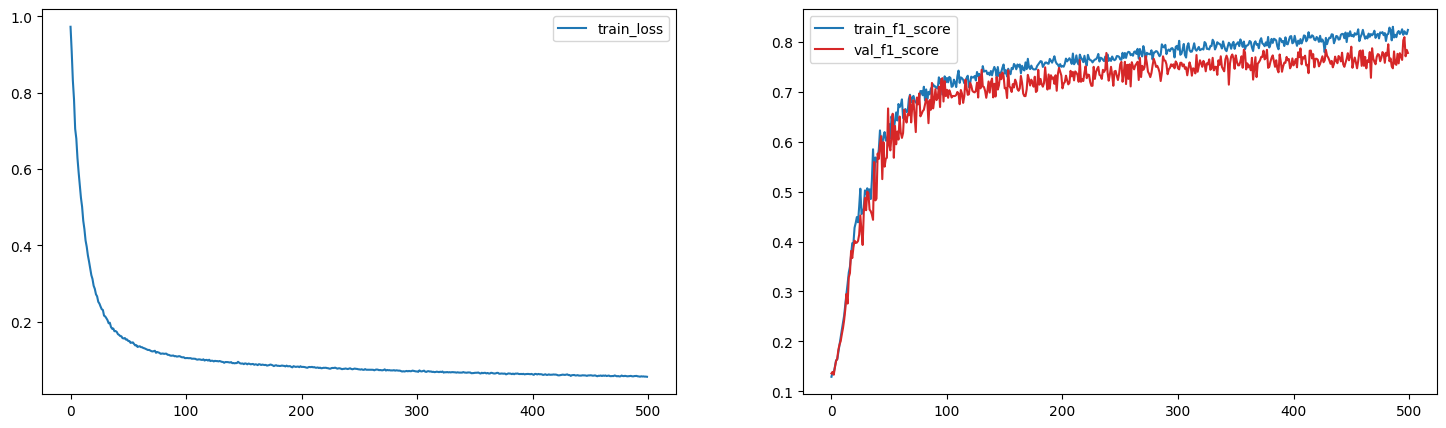

In [33]:
fig, ax = plt.subplots(1,2, figsize=(18,5), sharex=True)
ax[0].plot(metrics["loss"]['train'], label='train_loss', color='C0')
ax[1].plot(metrics['f1_score']['train'], label='train_f1_score', color='C0')
ax[1].plot(metrics['f1_score']['val'], label='val_f1_score', color='C3')
ax[0].legend()
ax[1].legend();

In [34]:
f1 = f1_score(data.y.cpu()[test_indices], y.cpu()[test_indices])
acc = accuracy_score(data.y.cpu()[test_indices], y.cpu()[test_indices])
pre = precision_score(data.y.cpu()[test_indices], y.cpu()[test_indices])
rec = recall_score(data.y.cpu()[test_indices], y.cpu()[test_indices])
print("test performance:")
print(f"\t f1: {f1}")
print(f"\t acc: {acc}")
print(f"\t pre: {pre}")
print(f"\t rec: {rec}")
print(confusion_matrix(data.y.cpu()[test_indices], y.cpu()[test_indices]))

test performance:
	 f1: 0.7468879668049793
	 acc: 0.9726457399103139
	 pre: 0.8256880733944955
	 rec: 0.6818181818181818
[[2079   19]
 [  42   90]]
